In [1]:
import pandas as pd
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
from datetime import timedelta
import datetime

# Please read, my idea was to classify the data into three cateogries: "UP", "DOWN", "NEUTRAL"
# UP - the price of the stock is up MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# DOWN - the price of the stock is down MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# NEUTRAL - the price of stock is did not rise or fall past the MINIMUM_GAIN threshhold
#
# EXAMPLE: LOOK_AHEAD_DAYS = 30, MINIMUM_GAIN = .05 (5%). If stock is up over 5% ore more after 30 days, 
# we mark it as 'UP'. If the stock is down 5% or more after 30 days, we mark it as 'DOWN'. If the stock
# is neither up nor down 5%, then we mark it as 'NEUTRAL'

MINIMUM_GAIN = .05 #minimal gain to be considered up or down for classification
LOOK_AHEAD_DAYS = 30 #number of days into the future we are trying to predict

class Utilities:

    @staticmethod
    def getData(ticker, start_date, end_date):
        try:
            stock_data = data.DataReader(ticker,
                                         'yahoo',
                                         start_date,
                                         end_date)
            return stock_data
        except RemoteDataError:
            print('No data found for {t}'.format(t=ticker))
#just get the btc price points from the past year
start_date = datetime.datetime.now() - timedelta(365)
end_date = datetime.datetime.now() - timedelta(1)
btc_df = Utilities.getData('BTC-USD', str(start_date.strftime('%Y-%m-%d')), str(end_date.strftime('%Y-%m-%d')))
btc_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-07,11979.419922,11556.167969,11954.040039,11966.407227,1.948159e+10,11966.407227
2019-08-08,11970.458008,11709.745117,11953.469727,11862.936523,1.833999e+10,11862.936523
2019-08-09,11915.655273,11323.898438,11861.556641,11354.024414,1.812536e+10,11354.024414
2019-08-10,11523.579102,11248.294922,11349.740234,11523.579102,1.577437e+10,11523.579102
2019-08-11,11528.189453,11320.951172,11528.189453,11382.616211,1.364720e+10,11382.616211
...,...,...,...,...,...,...
2020-08-01,12034.144531,11018.129883,11758.764648,11053.614258,2.741007e+10,11053.614258
2020-08-02,11453.079102,11012.415039,11043.768555,11246.348633,2.027171e+10,11246.348633
2020-08-04,11786.617188,11158.285156,11203.823242,11747.022461,2.441125e+10,11747.022461


In [2]:
btc_df = btc_df.assign(MonthTrend=lambda x: "N/A") #introduce new column that will be the trend we are predicting
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

#Populate the classification column MonthTrend
for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
    if (end_date - current_date).days > LOOK_AHEAD_DAYS:
        look_ahead_date = current_date + timedelta(days=LOOK_AHEAD_DAYS)
        
        while True: #we need to keep adding days to the look_ahead_date because there is no index for that day
            if look_ahead_date in btc_df.index:
                break
            print(look_ahead_date)
            look_ahead_date = look_ahead_date + timedelta(days=1)
        
        #Here we check if the open price in the future is higher than today's open price.
        if btc_df.loc[pd.Timestamp(look_ahead_date)]['Open'] >= btc_df.loc[index]['Open'] * (1 + MINIMUM_GAIN):
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'UP'
        elif btc_df.loc[pd.Timestamp(look_ahead_date)]['Open'] <= btc_df.loc[index]['Open'] * (1 - MINIMUM_GAIN):
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'DOWN'
        else:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'NEUTRAL'
            
#Now delete all columns that have a MonthTrend value of N/A
btc_df = btc_df[btc_df.MonthTrend != 'N/A']

#Data is now fully processed and ready to be trained on the machine learning model
#There are 3 values for MonthTrend: UP, DOWN, NEUTRAL
btc_df

2019-10-27 00:00:00
2020-08-03 00:00:00


,High,Low,Open,Close,Volume,Adj Close,MonthTrend
Date,,,,,,,
2019-09-06,10558.673828,10348.918945,10353.931641,10517.254883,1.530737e+10,10517.254883,DOWN
2019-09-07,10595.637695,10409.090820,10518.114258,10441.276367,1.367057e+10,10441.276367,DOWN
2019-09-08,10450.311523,10144.929688,10443.228516,10334.974609,1.759594e+10,10334.974609,DOWN
2019-09-09,10394.353516,10020.573242,10336.408203,10115.975586,1.490681e+10,10115.975586,DOWN
2019-09-10,10215.948242,9980.776367,10123.035156,10178.372070,1.542806e+10,10178.372070,DOWN
...,...,...,...,...,...,...,...
2020-07-31,11794.775391,11239.682617,11322.570312,11759.592773,2.607567e+10,11759.592773,UP
2020-08-01,12034.144531,11018.129883,11758.764648,11053.614258,2.741007e+10,11053.614258,UP
2020-08-02,11453.079102,11012.415039,11043.768555,11246.348633,2.027171e+10,11246.348633,UP


In [3]:
# selecting the important feature open close
btc = btc_df[['Close','Open','MonthTrend']]
btc.head(10)

,Close,Open,MonthTrend
Date,,,
2019-09-06,10517.254883,10353.931641,DOWN
2019-09-07,10441.276367,10518.114258,DOWN
2019-09-08,10334.974609,10443.228516,DOWN
2019-09-09,10115.975586,10336.408203,DOWN
2019-09-10,10178.372070,10123.035156,DOWN
2019-09-11,10410.126953,10176.819336,DOWN
2019-09-12,10360.546875,10415.362305,NEUTRAL
2019-09-13,10358.048828,10345.403320,NEUTRAL
2019-09-14,10347.712891,10356.465820,NEUTRAL


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
Y = btc['MonthTrend']
X = btc.drop(['MonthTrend'], axis=1)
X = StandardScaler().fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=2)

In [5]:
# decision tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=45)
param_grid = {'splitter': ["best","random"],  
              'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
             'max_leaf_nodes':[10,50,None]}  
grid =  GridSearchCV(model_tree,param_grid,scoring="accuracy", cv=10, verbose=1,n_jobs=6)
grid.fit(X_train,Y_train)
print(grid.best_params_)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.5s


{'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_split': 8, 'splitter': 'random'}


[Parallel(n_jobs=6)]: Done 5506 tasks      | elapsed:    3.5s
[Parallel(n_jobs=6)]: Done 5760 out of 5760 | elapsed:    3.5s finished
C:\Users\dong\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [6]:
# error rate
model_tree = OneVsRestClassifier(DecisionTreeClassifier(criterion='gini',min_samples_split=2,splitter="best",max_features="auto",
                                    max_leaf_nodes=10,max_depth=6))
model_tree.fit(X_train,Y_train)
tree_error_rate = 1 - model_tree.score(X_test,Y_test)
tree_error_rate

0.38

In [7]:
model_tree.score(X_train, Y_train)

0.728448275862069

In [8]:
#confusion matrix and classification for testing
from sklearn.metrics import classification_report,multilabel_confusion_matrix,roc_curve, auc
import matplotlib.pylab as plt
prediction = model_tree.predict(X_test)
print(multilabel_confusion_matrix(Y_test, prediction))

[[[56 10]
  [14 20]]

 [[73  4]
  [20  3]]

 [[33 24]
  [ 4 39]]]


In [9]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

        DOWN       0.67      0.59      0.62        34
     NEUTRAL       0.43      0.13      0.20        23
          UP       0.62      0.91      0.74        43

    accuracy                           0.62       100
   macro avg       0.57      0.54      0.52       100
weighted avg       0.59      0.62      0.57       100



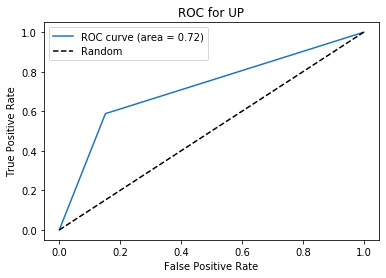

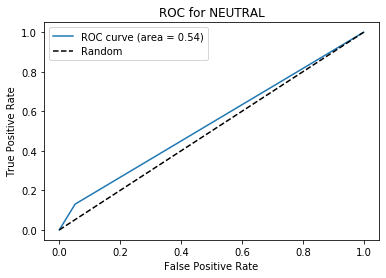

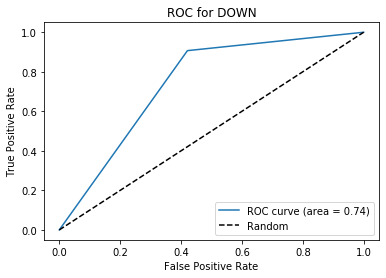

In [10]:
 # Plot the ROC curve

def plot_roc(Y_test,Y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes= 3
    Y_test_dummies = pd.get_dummies(Y_test, drop_first=False).values
    Y_pred_dummies = pd.get_dummies(Y_pred,drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_dummies[:, i],Y_pred_dummies[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    title = ["ROC for UP","ROC for NEUTRAL","ROC for DOWN"]
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--', label="Random")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title[i])
        plt.legend(loc="best")
        plt.show()
plot_roc(Y_test,prediction)

In [11]:
# random forest
from sklearn.ensemble import RandomForestClassifier
model_random = RandomForestClassifier(random_state=42)
param_grid = {
             'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
              'min_samples_leaf':[1,2,4,6],
             'max_leaf_nodes':[10,50,None]}  
random_grid =  GridSearchCV(model_random,param_grid,scoring="accuracy", cv=10, verbose=1,n_jobs=6)
random_grid.fit(X_train,Y_train)
print(random_grid.best_params_)

Fitting 10 folds for each of 1152 candidates, totalling 11520 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 2420 tasks      | elapsed:    6.4s
[Parallel(n_jobs=6)]: Done 6420 tasks      | elapsed:   17.3s


{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 8}


[Parallel(n_jobs=6)]: Done 11520 out of 11520 | elapsed:   33.4s finished
C:\Users\dong\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\dong\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [12]:
model_random_tree = OneVsRestClassifier(RandomForestClassifier(criterion= 'gini',min_samples_split=2,max_features="auto",
                                    max_leaf_nodes=10,max_depth=6,min_samples_leaf=6))
model_random_tree.fit(X_train,Y_train)
tree_error_rate = 1 - model_random_tree.score(X_test,Y_test)
tree_error_rate

C:\Users\dong\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dong\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dong\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.39

In [13]:
model_random_tree.score(X_train, Y_train)

0.6767241379310345

In [17]:
new_prediction = model_random_tree.predict(X_test)
print(multilabel_confusion_matrix(Y_test, new_prediction))

[[[54 12]
  [14 20]]

 [[74  3]
  [19  4]]

 [[33 24]
  [ 6 37]]]


In [18]:
print(classification_report(Y_test, new_prediction))

              precision    recall  f1-score   support

        DOWN       0.62      0.59      0.61        34
     NEUTRAL       0.57      0.17      0.27        23
          UP       0.61      0.86      0.71        43

    accuracy                           0.61       100
   macro avg       0.60      0.54      0.53       100
weighted avg       0.60      0.61      0.57       100



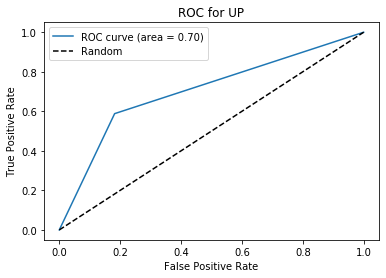

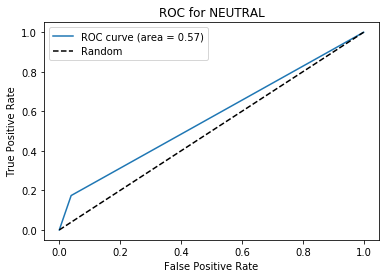

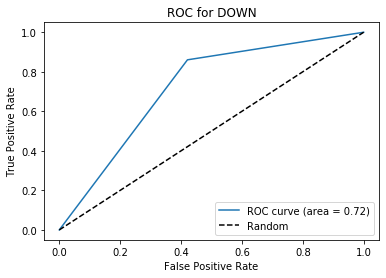

In [19]:
plot_roc(Y_test,new_prediction)